In [1]:
import requests
import re
import urllib 
import os
import xarray as xr

from shapely.geometry import Point
import geopandas as gpd
import numpy as np

from scipy.interpolate import griddata


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def palau_eez(df):
    df_eez = gpd.read_file('../palauEEZ.geojson')
    eez = df_eez['geometry'].values[0]
    in_palau = []
    longlat = df[['longitude','latitude']].values.tolist()
    for x in longlat:
        point = Point(x[0],x[1])
        if eez.contains(point) or point.within(eez):
            in_palau.append((x[0],x[1]))
    return df[df[['longitude', 'latitude']].apply(tuple, axis=1).isin(in_palau)]

In [3]:
def filter_palau(df):
    filtered = df[(df["latitude"]>= 1.25)&
                                (df["latitude"]<=13.00)&(df["longitude"]<=139.00)&
                                (df["longitude"]>=128)]
    return filtered

## Source of NOAA OI-SST Monthly
http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_31a3_72d5_401e.html

In [4]:
#Download directory
download_folder = './oisst/'

In [5]:
if not os.path.exists(download_folder):
    os.makedirs(download_folder)

In [6]:
minlat = -35.0
maxlat = 35.0
minlon = 125.0
maxlon = 360.0-115.0
date_static = '1985-12-31'

In [6]:
#Palau ONLY
# oisst_download = "http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_31a3_72d5_401e.nc?sst[(1854-01-15):1:(2023-12-15T00:00:00Z)][(1.5214):1:(11.6587)][(129.4088):1:(137.0541)],ssta[(1854-01-15):1:(2023-12-15T00:00:00Z)][(1.5214):1:(11.6587)][(129.4088):1:(137.0541)]"

In [7]:
#Pacific Region
oisst_download = "http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_31a3_72d5_401e.nc?sst[(1854-01-15):1:(2023-12-15T00:00:00Z)][(-35.0):1:(35.0)][(125):1:(245)],ssta[(1854-01-15):1:(2023-12-15T00:00:00Z)][(-35.0):1:(35.0)][(125):1:(245)]"

In [1]:
360.0-115.0

245.0

In [11]:
urllib.request.urlretrieve(oisst_download, download_folder + 'hawaii_soest_f377_d8b2_5d80Pacific_RIM.nc')

('./oisst/hawaii_soest_f377_d8b2_5d80Pacific_RIM.nc',
 <http.client.HTTPMessage at 0x7ff1a8c72b20>)

In [ ]:
#Alternative way to load in dataset instead of downloading directly to a folder
oisst = xr.open_dataset(oisst_download, decode_times=True)

In [8]:
oisst = xr.open_dataset(download_folder + 'hawaii_soest_f377_d8b2_5d80Pacific_RIM.nc')
oisst_sst = oisst.sst
oisst_df = oisst_sst.to_dataframe()
oisst_df = oisst_df.reset_index()
oisst_df

,time,latitude,longitude,sst
0,1854-01-15,-34.0,126.0,18.936335
1,1854-01-15,-34.0,128.0,19.119284
2,1854-01-15,-34.0,130.0,19.196617
3,1854-01-15,-34.0,132.0,19.260378
4,1854-01-15,-34.0,134.0,19.393604
...,...,...,...,...
4479835,2023-12-15,36.0,238.0,NaN
4479836,2023-12-15,36.0,240.0,NaN
4479837,2023-12-15,36.0,242.0,NaN
4479838,2023-12-15,36.0,244.0,NaN


In [33]:
sst_oisst = oisst['sst'].loc[{'latitude': slice(minlat,maxlat),
                              'longitude': slice(minlon,maxlon), 
                             'time': slice(date_static,date_static)}]

In [37]:
sst_oisst

<xarray.DataArray 'sst' (time: 0, latitude: 35, longitude: 60)>
[0 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 
  * latitude   (latitude) float64 -34.0 -32.0 -30.0 -28.0 ... 30.0 32.0 34.0
  * longitude  (longitude) float64 126.0 128.0 130.0 132.0 ... 240.0 242.0 244.0
Attributes:
    direction:      IJL
    ioos_category:  Temperature
    long_name:      extended reconstructed sea surface temperature [degree c]

In [47]:
# oisst_df = palau_eez(oisst_df) 
oisst_df

,time,latitude,longitude,sst
0,1854-01-15,2.0,130.0,28.338690
1,1854-01-15,2.0,132.0,28.436239
2,1854-01-15,2.0,134.0,28.460934
3,1854-01-15,2.0,136.0,28.542139
4,1854-01-15,2.0,138.0,28.637644
...,...,...,...,...
61195,2023-12-15,12.0,130.0,NaN
61196,2023-12-15,12.0,132.0,NaN
61197,2023-12-15,12.0,134.0,NaN
61198,2023-12-15,12.0,136.0,NaN


In [13]:
oisst_cleaned = oisst_df[~oisst_df["sst"].isnull()]

In [14]:
oisst_cleaned = oisst_cleaned.reset_index(drop = True)
oisst_cleaned

,time,latitude,longitude,sst
0,1854-01-15,-34.0,126.0,18.936335
1,1854-01-15,-34.0,128.0,19.119284
2,1854-01-15,-34.0,130.0,19.196617
3,1854-01-15,-34.0,132.0,19.260378
4,1854-01-15,-34.0,134.0,19.393604
...,...,...,...,...
4177831,2023-06-15,36.0,230.0,16.160124
4177832,2023-06-15,36.0,232.0,15.589234
4177833,2023-06-15,36.0,234.0,14.863866
4177834,2023-06-15,36.0,236.0,13.992193


In [9]:
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader

In [10]:
# add mapping routines
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

In [18]:
oisst_cleaned

,time,latitude,longitude,sst
0,1854-01-15,-34.0,126.0,18.936335
1,1854-01-15,-34.0,128.0,19.119284
2,1854-01-15,-34.0,130.0,19.196617
3,1854-01-15,-34.0,132.0,19.260378
4,1854-01-15,-34.0,134.0,19.393604
...,...,...,...,...
4177831,2023-06-15,36.0,230.0,16.160124
4177832,2023-06-15,36.0,232.0,15.589234
4177833,2023-06-15,36.0,234.0,14.863866
4177834,2023-06-15,36.0,236.0,13.992193


In [19]:
oisst_cleaned[oisst_cleaned['time'] > '1985-12-31']

,time,latitude,longitude,sst
3253536,1986-01-15,-34.0,126.0,19.105904
3253537,1986-01-15,-34.0,128.0,19.179323
3253538,1986-01-15,-34.0,130.0,19.185036
3253539,1986-01-15,-34.0,132.0,19.155237
3253540,1986-01-15,-34.0,134.0,19.179888
...,...,...,...,...
4177831,2023-06-15,36.0,230.0,16.160124
4177832,2023-06-15,36.0,232.0,15.589234
4177833,2023-06-15,36.0,234.0,14.863866
4177834,2023-06-15,36.0,236.0,13.992193


In [20]:
oisst_slice = oisst_cleaned[oisst_cleaned['time'] == '1986-01-15'].reset_index(drop = True)

In [21]:
oisst_slice

,time,latitude,longitude,sst
0,1986-01-15,-34.0,126.0,19.105904
1,1986-01-15,-34.0,128.0,19.179323
2,1986-01-15,-34.0,130.0,19.185036
3,1986-01-15,-34.0,132.0,19.155237
4,1986-01-15,-34.0,134.0,19.179888
...,...,...,...,...
2049,1986-01-15,36.0,230.0,14.854559
2050,1986-01-15,36.0,232.0,14.307184
2051,1986-01-15,36.0,234.0,13.827119
2052,1986-01-15,36.0,236.0,13.427476


In [27]:
# sst_oisst = oisst_df[oisst_df['time'] == '1986-01-15'].reset_index(drop = True)

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_33942/1017871972.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',


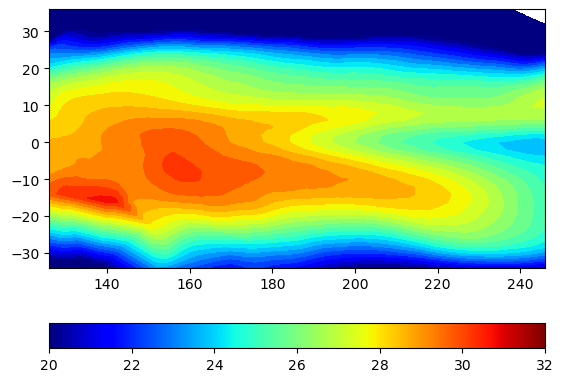

In [22]:
vmin, vmax = 20, 32

x_orig = np.asarray(oisst_slice.longitude.tolist())
y_orig = np.asarray(oisst_slice.latitude.tolist())
z_orig = np.asarray(oisst_slice.sst.tolist())

x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')

ctf = plt.contourf(x_mesh, y_mesh,z_mesh, 50,
             vmin=vmin,vmax=vmax, cmap=cm.jet)

plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             ticks = range(vmin,vmax+2,2))
# ctf = plt.contourf(oisst_slice['longitude'], oisst_slice['latitude'], oisst_slice.squeeze(), 50,
#              vmin=vmin,vmax=vmax, cmap=cm.jet)

In [12]:
oisst_sample = oisst.loc[{'time': slice('1986-01-15','1986-01-15')}]
x = oisst_sample.variables['longitude'][:].squeeze()
y = oisst_sample.variables['latitude'][:].squeeze()
z = oisst_sample.variables['sst'][:].squeeze()

In [ ]:
vmin, vmax = 20, 32

x_orig = np.asarray(oisst_slice.longitude.tolist())
y_orig = np.asarray(oisst_slice.latitude.tolist())
z_orig = np.asarray(oisst_slice.sst.tolist())

x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')

# ctf = plt.contourf(x_mesh, y_mesh,z_mesh, 50,
#              vmin=vmin,vmax=vmax, cmap=cm.jet)

plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             ticks = range(vmin,vmax+2,2))
# ctf = plt.contourf(oisst_slice['longitude'], oisst_slice['latitude'], oisst_slice.squeeze(), 50,
#              vmin=vmin,vmax=vmax, cmap=cm.jet)

# ctf = plt.contourf(sst_crw['longitude'], sst_crw['latitude'], sst_crw.squeeze(), 50,
#              vmin=vmin, vmax=vmax, cmap=cm.jet, extend='both', transform=ccrs.PlateCarree())

# ctf = plt.contourf(oisst_slice['longitude'], oisst_slice['latitude'], oisst_slice.squeeze(), 50,
#              vmin=vmin,vmax=vmax, cmap=cm.jet, extend = 'both', transform=ccrs.PlateCarree())

# ctf = plt.contourf(x_mesh, y_mesh,z_mesh, 50,
#              vmin=vmin,vmax=vmax, cmap=cm.jet)

ax1 = plt.subplot(2,2,1,projection = ccrs.PlateCarree(central_longitude=180.0))




/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_33942/2407407275.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_33942/2407407275.py:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(2,2,1,projection = ccrs.PlateCarree(central_longitude=180.0))


AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'

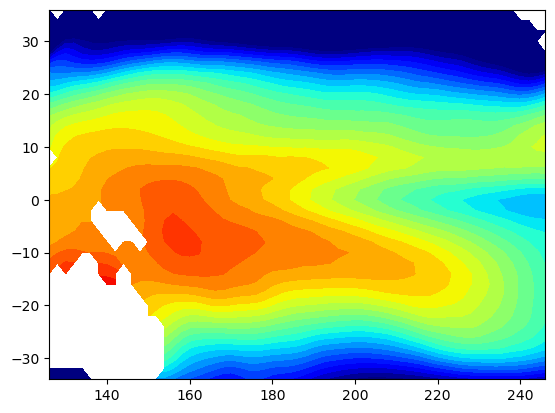

In [17]:
vmin, vmax = 20, 32
# fig = plt.subplots( figsize = (18, 20) )

# # 2. Plot OISST
# # set projection, center on the Pacific
# ax2 = plt.subplot(2,2,2,projection = ccrs.PlateCarree(central_longitude=180.0))

# # add coastlines
# ax2.add_feature(cf.COASTLINE)

# # add lat/lon labels (left and bottom)
# gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
#                 alpha=0.75, linestyle='--')
# gl.xlabels_top = False
# gl.ylabels_right = False

# # set label size and color
# gl.xlabel_style = {'size':15, 'color': 'black'}
# gl.ylabel_style = {'size':15, 'color': 'black'}

# # specify where to label
# gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
# gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# # specify how to label
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER

ctf = plt.contourf(x, y, z, 50,
             vmin=vmin,vmax=vmax, cmap=cm.jet)

#                    , extend = 'both', transform=ccrs.PlateCarree())

In [14]:
conda install cartopy=0.21

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized


Note: you may need to restart the kernel to use updated packages.


In [ ]:
 conda install matplotlib=3.5.2

TypeError: Length of x (26442) must match number of columns in z (4)

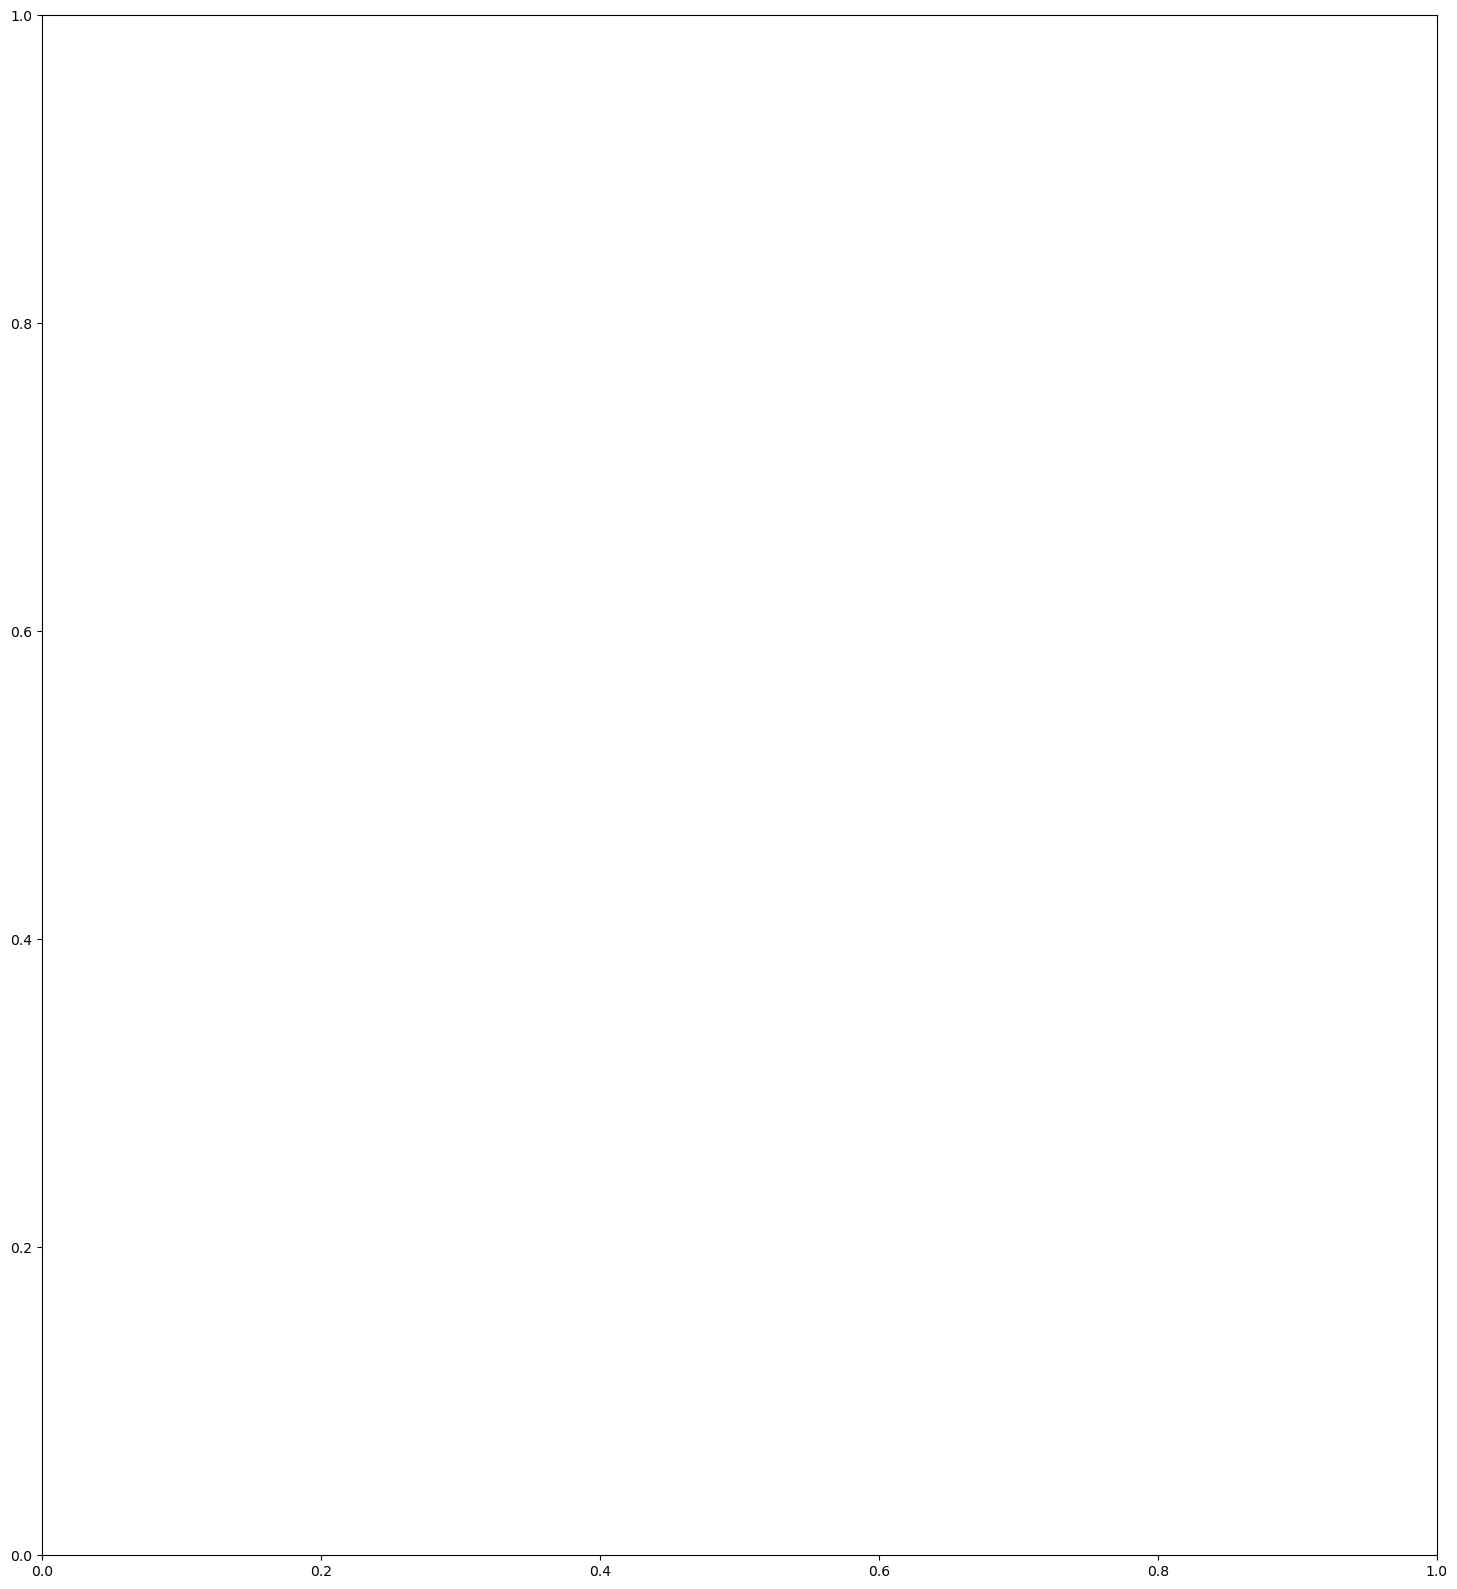

In [19]:
# set up the figure
fig = plt.subplots( figsize = (18, 20) )

# set color range
vmin, vmax = 20, 32

# # 2. Plot OISST
# # set projection, center on the Pacific
# ax2 = plt.subplot(2,2,2,projection = ccrs.PlateCarree(central_longitude=180.0))

# # add coastlines
# ax2.add_feature(cf.COASTLINE)

# # add lat/lon labels (left and bottom)
# gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
#                 alpha=0.75, linestyle='--')
# gl.xlabels_top = False
# gl.ylabels_right = False

# # set label size and color
# gl.xlabel_style = {'size':15, 'color': 'black'}
# gl.ylabel_style = {'size':15, 'color': 'black'}

# # specify where to label
# gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
# gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# # specify how to label
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER


# plot variable
ctf = plt.contourf(oisst_cleaned['longitude'], oisst_cleaned['latitude'], oisst_cleaned.squeeze(), 50,
             vmin=vmin,vmax=vmax, cmap=cm.jet)
#                    , extend = 'both', transform=ccrs.PlateCarree())


# # add EEZ's as black lines
# for i, row in shpf180.iterrows():
#     geom = row.geometry
#     sp = ShapelyFeature([geom],ccrs.PlateCarree(central_longitude=180.0),
#                         edgecolor='black',facecolor='none',lw=0.7)
#     ax2.add_feature(sp)

# Add a colorbar and title
#plt.colorbar(ctf,orientation='horizontal',ax=ax2)
plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             ticks = range(vmin,vmax+2,2))
plt.title('OI SST ' + date_static_t)
